In [ ]:
pip install deeplake

In [ ]:
pip install opencv-python


In [ ]:
!pip install torch torchvision albumentations


In [ ]:
pip install tensorflow


In [ ]:
ds2 = deeplake.load("hub://activeloop/carpk-test")

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-test



\

hub://activeloop/carpk-test loaded successfully.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import packages

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
ds = deeplake.load("hub://activeloop/carpk-train")

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-train



/

hub://activeloop/carpk-train loaded successfully.



# 1 Exploratory Data Analysis

### **1.1 Check Dataset Structure**

In [ ]:
# Check dataset structure
ds.summary()


Dataset(path='hub://activeloop/carpk-train', read_only=True, tensors=['images', 'boxes', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (989, 720, 1280, 3)   uint8    jpeg   
  boxes      bbox        (989, 1:87, 4)     float32   None   
 labels   class_label      (989, 1:87)      uint32    None   



Images: There are now 989 images compared to 459 in the test dataset.

Bounding boxes: Each image has between 1 and 87 objects (cars) annotated in the form of bounding boxes.

Labels: Correspond to the object classes, likely indicating the number of cars, and have the same range as the bounding boxes (between 1 and 87 labels per image).

### 1.2 **Visualize Sample Images**

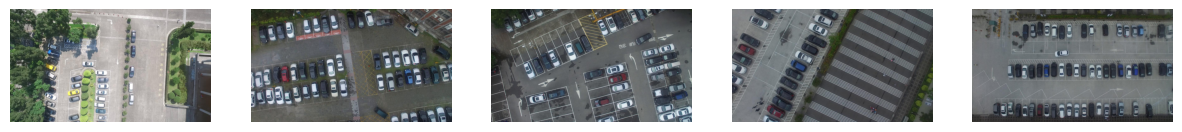

In [ ]:
# Function to display sample images
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        sample = dataset['images'][i].numpy()  # Accessing the image tensor
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample)
        plt.axis('off')

    plt.show()

# Display 5 sample images
show_sample_images(ds, num_samples=5)


### 1.3 **Check Image and Label Distribution**

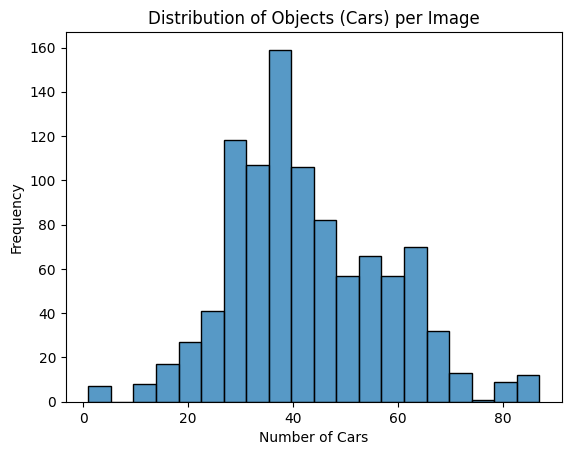

In [ ]:
# Get the number of bounding boxes (cars) in each image
object_counts = [len(sample['boxes'].numpy()) for sample in ds]

# Plot the distribution of object counts per image
sns.histplot(object_counts, bins=20)
plt.title('Distribution of Objects (Cars) per Image')
plt.xlabel('Number of Cars')
plt.ylabel('Frequency')
plt.show()



Most images have between 30 to 50 cars, with the peak at around 40 cars per image.

A small number of images contain fewer than 20 cars or more than 70 cars.

The distribution is fairly balanced, though there are some outliers with very few or many cars.

### 1.4 **Visualize Bounding Boxes on Images (Object Density)**

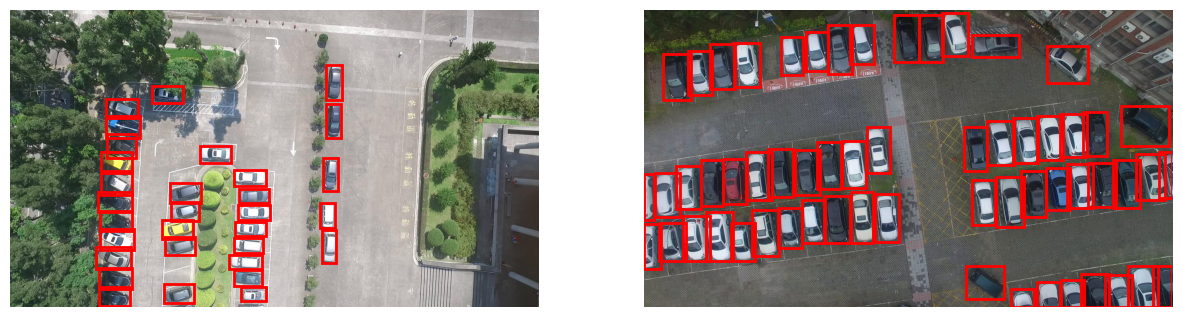

In [ ]:
# Function to display images with bounding boxes using [x_min, y_min, width, height]
def show_original_images_with_boxes_corrected(dataset, num_samples=3):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        # Access the original image
        sample_image = dataset['images'][i].numpy()
        img_height, img_width, _ = sample_image.shape

        # Access the bounding boxes
        boxes = dataset['boxes'][i].numpy()

        # Plot the image
        ax = plt.subplot(1, num_samples, i+1)
        ax.imshow(sample_image)

        # Add bounding boxes
        for box in boxes:
            x_min, y_min, width, height = box  # New format with width and height
            rect = patches.Rectangle(
                (x_min, y_min),  # Start point (top-left corner)
                width,           # Box width
                height,          # Box height
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.axis('off')

    plt.show()

# Display original images with corrected bounding boxes
show_original_images_with_boxes_corrected(ds, num_samples=2)


### **1.5 Check for Missing or Corrupt Data**

In [ ]:
# Check for missing or corrupt data
missing_data_count = 0

for i, sample in enumerate(ds):
    if sample['images'] is None or sample['boxes'] is None or sample['labels'] is None:
        print(f"Missing data in sample {i}")
        missing_data_count += 1

if missing_data_count == 0:
    print("No missing or corrupt data found!")
else:
    print(f"Total samples with missing data: {missing_data_count}")


No missing or corrupt data found!


# 2 Exploratory Data Analysis

### **2.1 Resize Images and Scale Bounding Boxes**

/usr/local/lib/python3.10/dist-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


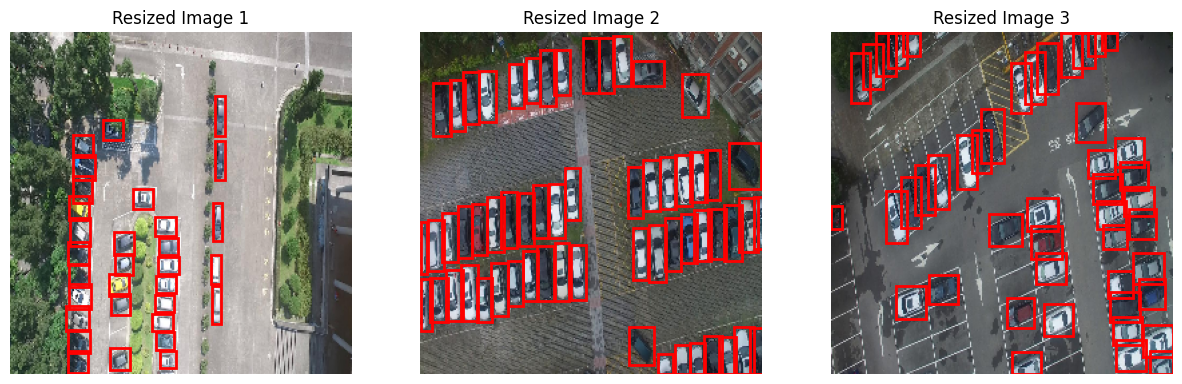

In [ ]:
# Function to resize images and scale bounding boxes for the entire dataset
def resize_images_and_boxes(dataset, new_size=(256, 256)):
    resized_images = []
    resized_boxes = []

    original_size = (720, 1280)

    # Loop through all images in the dataset
    for i in range(len(dataset['images'])):
        # Resize image
        sample_image = dataset['images'][i].numpy()
        resized_image = cv2.resize(sample_image, new_size)
        resized_images.append(resized_image)

        # Scale bounding boxes according to the new image size
        sample_boxes = dataset['boxes'][i].numpy()
        x_scale = new_size[1] / original_size[1]  # Width scaling factor
        y_scale = new_size[0] / original_size[0]  # Height scaling factor

        resized_box = []
        for box in sample_boxes:
            x_min, y_min, width, height = box
            resized_box.append([x_min * x_scale, y_min * y_scale, width * x_scale, height * y_scale])
        resized_boxes.append(resized_box)

    return resized_images, resized_boxes

# Resize all images and adjust bounding boxes
resized_images, resized_boxes = resize_images_and_boxes(ds, new_size=(256, 256))

# Function to visualize resized images with bounding boxes
def show_resized_images_with_boxes(resized_images, resized_boxes, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i, img in enumerate(resized_images[:num_samples]):
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(img)

        # Draw bounding boxes
        for box in resized_boxes[i]:
            x_min, y_min, width, height = box
            rect = patches.Rectangle(
                (x_min, y_min),  # Start point (top-left corner)
                width,           # Box width
                height,          # Box height
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.title(f"Resized Image {i+1}")
        plt.axis('off')

    plt.show()

# Display a few resized images with bounding boxes
show_resized_images_with_boxes(resized_images, resized_boxes, num_samples=3)


### **2.2 Normalize Pixel Values**

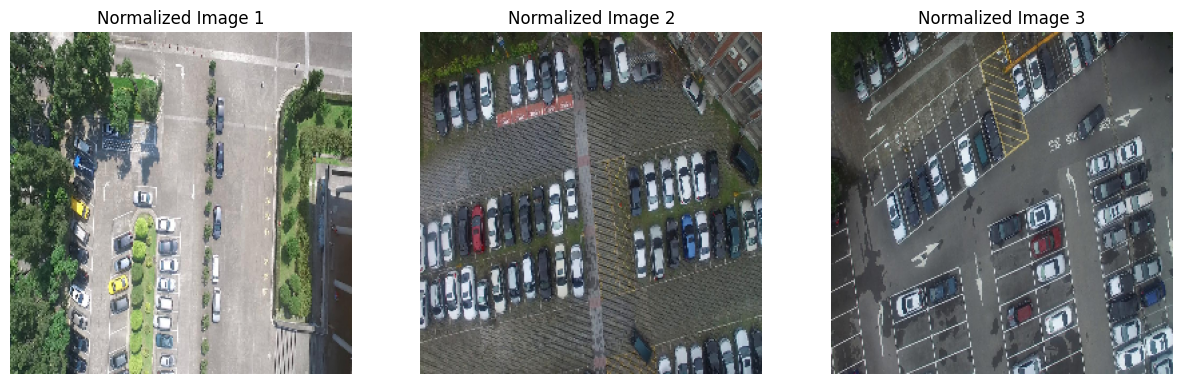

In [ ]:
# Function to normalize the images

def normalize_images(resized_images):
    normalized_images = []
    for image in resized_images:
        normalized_image = image / 255.0  # Normalize pixel values to the range [0, 1]
        normalized_images.append(normalized_image)
    return normalized_images

# Normalize the resized images
normalized_images = normalize_images(resized_images)

# Function to visualize a subset of the normalized images (for clarity)
def show_normalized_images(resized_images, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(resized_images[:num_samples]):  # Visualize only a few images
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(img)
        plt.title(f"Normalized Image {i+1}")
        plt.axis('off')
    plt.show()

# Display a few normalized images
show_normalized_images(normalized_images, num_samples=3)


In [ ]:
# Check the total number of images
print(f"Total number of images: {len(normalized_images)}")
print(f"Total number of bounding boxes: {len(resized_boxes)}")


Total number of images: 989
Total number of bounding boxes: 989


# 3 Model training

### **3.1 Data augmentation**

In [ ]:
# Define augmentation pipeline with additional transformations
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomCrop(height=224, width=224, p=0.5),
    A.GaussianBlur(p=0.2),
    A.ColorJitter(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

# Function to apply augmentations to images and adjust bounding boxes
def augment_data(images, boxes):
    augmented_images = []
    augmented_boxes = []

    for i, image in enumerate(images):
        box = boxes[i]

        # Convert bounding boxes to the format expected by Albumentations (x_min, y_min, x_max, y_max)
        box_albumentations = []
        for b in box:
            x_min, y_min, width, height = b
            x_max = x_min + width
            y_max = y_min + height
            box_albumentations.append([x_min, y_min, x_max, y_max])

        # Apply augmentation
        augmented = augmentation_pipeline(image=image, bboxes=box_albumentations)
        augmented_images.append(augmented['image'])

        # Convert bounding boxes back to the original format (x_min, y_min, width, height)
        aug_boxes = []
        for b in augmented['bboxes']:
            x_min, y_min, x_max, y_max = b
            aug_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
        augmented_boxes.append(aug_boxes)

    return augmented_images, augmented_boxes


### 3.2 **CNN-Based Object Counting Model**

#### **3.2.1** **Prepare Data for Training**



#### **3.2.1.1 Image Resizing and Normalization for CNN Training**
(after applying augmentation)

In [ ]:
# Function to resize images to a fixed size
def resize_images_to_fixed_size(images, target_size=(256, 256)):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, target_size)
        resized_images.append(resized_image)
    return resized_images

# Apply augmentation to the training set
augmented_train_images, augmented_train_boxes = augment_data(resized_images, resized_boxes)

# Resize augmented images to a fixed size
augmented_train_images = resize_images_to_fixed_size(augmented_train_images, target_size=(256, 256))

# Convert the augmented images to numpy arrays after resizing
train_images_np = np.array(augmented_train_images)
train_images_np = train_images_np / 255.0  # Normalize images for the CNN model

# Reshape images for model training
train_images_np = train_images_np.reshape((-1, 256, 256, 3))


### **3.2.2 Object Counting and Image Preparation for CNN Training**

In [ ]:
# Convert bounding boxes to object counts (number of cars in each image)
def get_object_counts(boxes):
    """
    Convert bounding boxes to object counts by counting the number of bounding boxes in each image.
    """
    return np.array([len(b) for b in boxes])

# Get object counts from bounding boxes (for augmented boxes)
train_counts = get_object_counts(augmented_train_boxes)

# Convert image data to numpy arrays for model input
train_images_np = np.array(augmented_train_images)  # Augmented images (preprocessed)

# Ensure that all images are of the same shape before converting to numpy array
train_images_np = np.stack([cv2.resize(img, (256, 256)) for img in train_images_np])

# Normalize images for the CNN model (values between 0 and 1)
train_images_np = train_images_np / 255.0

# Reshape images for model training if needed
train_images_np = train_images_np.reshape((-1, 256, 256, 3))

# Print the shape of the prepared arrays for verification
print(f"Train images shape: {train_images_np.shape}")
print(f"Train counts shape: {train_counts.shape}")


Train images shape: (989, 256, 256, 3)
Train counts shape: (989,)


### **3.2.3 CNN Model for Object Counting**

In [ ]:
# Define the enhanced CNN model with increased complexity and regularization
def create_enhanced_cnn_model(input_shape, l2_penalty=0.001):
    model = models.Sequential()

    # First Convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_penalty), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional block (added more layers)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Fully connected layer with Dropout for regularization
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.6))  # Increased dropout to prevent overfitting

    # Output layer (regression for object count)
    model.add(layers.Dense(1, activation='linear'))  # Output is a single count

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Create the enhanced CNN model
enhanced_cnn_model = create_enhanced_cnn_model(input_shape=(256, 256, 3))

# Display the model summary to check the number of parameters
enhanced_cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,236,929 (50.49 MB)

 Trainable params: 13,235,457 (50.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

### **3.2.3 training**

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 259ms/step - loss: 2014.2487 - mae: 42.3068 - val_loss: 2974.3943 - val_mae: 52.0556 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1978.8168 - mae: 42.0178 - val_loss: 2944.5703 - val_mae: 51.7537 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1868.8505 - mae: 41.0070 - val_loss: 3042.3086 - val_mae: 52.7245 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1628.0940 - mae: 38.1618 - val_loss: 2364.9661 - val_mae: 45.9465 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1374.3462 - mae: 34.8450 - val_loss: 2559.7158 - val_mae: 48.4299 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1112.8307 - mae: 30.9969 - val_loss: 1924.0748 - val_mae: 41.7251 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 849.4074 - mae: 26.3981 - val_loss: 11

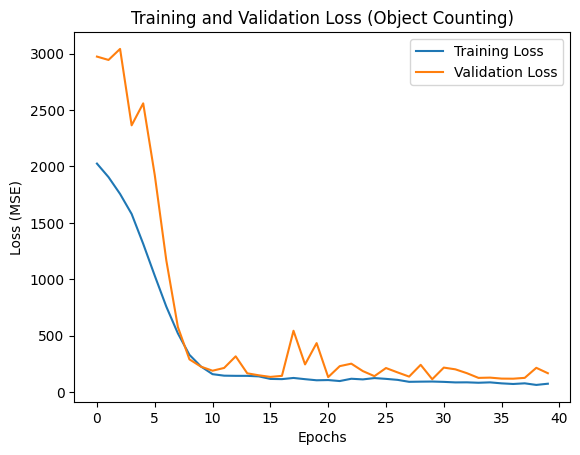

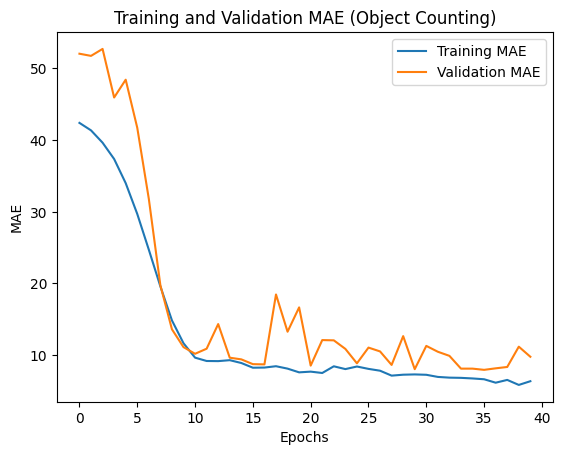

In [ ]:
# Early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the CNN model with enhanced complexity and regularization
history = enhanced_cnn_model.fit(
    train_images_np,  # Input images
    train_counts,     # Target object counts (number of cars)
    epochs=100,       # Number of epochs
    batch_size=16,    # Adjusted batch size for faster convergence
    validation_split=0.2,  # Split 20% of the data for validation
    callbacks=[early_stopping, reduce_lr]  # Early stopping and learning rate adjustment
)

# Plot the training and validation loss (for visualization)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Object Counting)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot the training and validation MAE (Mean Absolute Error)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE (Object Counting)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### **3.3 Testing**

###  **3.3.1 Test Image Preprocessing for CNN Input**

In [ ]:
ds2 = deeplake.load("hub://activeloop/carpk-test")
# Resize and normalize test images
def preprocess_test_images(ds2, new_size=(256, 256)):
    preprocessed_images = []
    for i in range(len(ds2['images'])):
        img = ds2['images'][i].numpy()
        resized_img = cv2.resize(img, new_size)
        normalized_img = resized_img / 255.0  # Normalize to [0, 1]
        preprocessed_images.append(normalized_img)
    return np.array(preprocessed_images)

# Preprocess the test images
test_images_np = preprocess_test_images(ds2)

# Reshape the images for model input (batch_size, height, width, channels)
test_images_np = test_images_np.reshape((-1, 256, 256, 3))


/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-test



/

hub://activeloop/carpk-test loaded successfully.



/usr/local/lib/python3.10/dist-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


### **3.3.2 Object Count Prediction on Test Set**

In [ ]:
# Predict the object count (cars) on the test set
predicted_counts = enhanced_cnn_model.predict(test_images_np)

# Print the predicted counts for the first few test images
print("Predicted car counts for the first few test images:", predicted_counts[:10])


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted car counts for the first few test images: [[64.98312 ]
 [47.78616 ]
 [64.06051 ]
 [47.76213 ]
 [55.828495]
 [40.738434]
 [68.283714]
 [61.015846]
 [64.8244  ]
 [83.12199 ]]


### **3.3.4 Actual Object Count Extraction from Test Set**

In [ ]:
# Get the actual car counts from the bounding boxes in the test set
def get_actual_counts(dataset):
    actual_counts = [len(dataset['boxes'][i].numpy()) for i in range(len(dataset['images']))]
    return np.array(actual_counts)

# Get actual car counts for the test set
actual_counts = get_actual_counts(ds2)

# Print the actual counts for the first few test images
print("Actual car counts for the first few test images:", actual_counts[:10])


Actual car counts for the first few test images: [120 110  87  56  91  42 164 116 118 136]


### **3.3.5 Evaluation of Prediction Accuracy**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the Mean Absolute Error (MAE) between predicted and actual counts
mae = mean_absolute_error(actual_counts, predicted_counts)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual_counts, predicted_counts)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 48.851129897539394
Mean Squared Error (MSE): 3029.452523166749


### **Improving 3.2.3**